In [ ]:
import os, glob, re, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import matplotlib.pyplot as plt
# %matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers, activations, optimizers, losses, metrics, initializers
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls "/content/drive/My Drive"

 abc.py			      dummydata.gsheet
'air travel dataset.gsheet'   model.txt
'And Begin.gdoc'	     'My Files'
 Classroom		      saveimg.txt
'Colab Notebooks'	      Social_Network_Ads.csv
'Copy of Students_wf.csv'    'Untitled document.gdoc'
 Dataset_BUSI_with_GT	     'web dev'
'dummydata (1).gsheet'	     'yahoo Finanace_industry - Stock Market.csv'


In [ ]:
def make_image(file): #to prepare the image
	# img = image.load_img(file, target_size=(224,224))
	# img_array = image.img_to_array(img)
	# img_array = img_array / 255.0
	img1 = cv2.imread(file)
	img1 = cv2.resize(img1, (224, 224))

	return img1

	# return tf.keras.applications.efficientnet.preprocess_input(img_array)

In [ ]:
import cv2
import numpy as np

def augment_image(image, num_augmentations=3):
    augmented_images = []

    for _ in range(num_augmentations):
        augmented_image = image.copy()

        # Randomly flip the image horizontally or vertically
        flip_choice = np.random.randint(0, 2)  # 0 for horizontal flip, 1 for vertical flip
        if flip_choice == 0:
            augmented_image = cv2.flip(augmented_image, 1)  # Horizontal flip
        else:
            augmented_image = cv2.flip(augmented_image, 0)  # Vertical flip

        augmented_images.append(augmented_image)

    return augmented_images


In [ ]:
imgb = cv2.imread(f'/content/im3.png')
ob = augment_image(imgb)

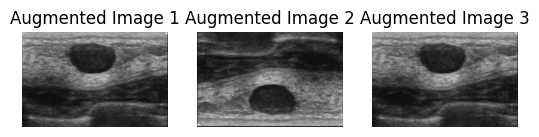

In [ ]:
for i, augmented_image in enumerate(ob):
    plt.subplot(1, len(ob), i + 1)  # Create a subplot
    plt.imshow(cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))  # Convert to RGB for Matplotlib
    plt.axis('off')  # Turn off axes
    plt.title(f"Augmented Image {i + 1}")

plt.show()

In [ ]:
#we are only using the unmasked files to prepare or model.
dir_path = '/content/drive/My Drive/Dataset_BUSI_with_GT'
directories = os.listdir(dir_path)
IMAGE_SHAPE = (224, 224)

In [ ]:
files_list =[]
label_list = []

for folder in directories: # runs 3 times only

	list1 = glob.glob(f'{dir_path}/{folder}/*') # will include all files inside the folder

	files_list.extend(list1)
	label_list.extend(folder for _ in list1)

len(files_list), len(label_list)

(1578, 1578)

In [ ]:
images_dict = {
	"image": [],
	"target": []
	}

for file, label in zip(files_list, label_list): #include all unmasked files

    if "mask" not in file:
        imx = make_image(file)
        images_dict["image"].append(imx)  #coz file must be first converted into an array or a list (array & list are same in py)
        images_dict["image"].extend(augment_image(imx))
        images_dict["target"].extend([label] * (3 + 1))

print('Finished.')

Finished.


In [ ]:
len(images_dict["image"]), len(images_dict["target"])

(3120, 3120)

In [ ]:
# converting lists to numpy arrays
images_dict['image'] = np.array(images_dict['image'])
images_dict['target'] = np.array(images_dict['target'])

In [ ]:
# encoding the label values
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

images_dict['target'] = le.fit_transform(images_dict['target'])

classes = le.classes_
print(f'Target classes are: {classes}')

Target classes are: ['benign' 'malignant' 'normal']


In [ ]:
# train test split:

x_train, x_test, y_train, y_test = train_test_split(images_dict['image'], images_dict['target'], test_size=0.1)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2808, 224, 224, 3), (312, 224, 224, 3), (2808,), (312,))

In [ ]:
images_dict["image"]

In [ ]:
# ResNet152V2 model with pre-trained weights is used from ImageNet dataset
# Model's weights are frozen so that we can add additional layers of our model on top of it.
# Transfer Learning.

from tensorflow.keras.applications import resnet_v2
# from tensorflow.keras.applications import mobilenet_v2.MobileNetV2
base_model = tf.keras.applications.MobileNetV2(
                                            include_top=False,
                                            weights='imagenet',
                                            input_shape=(*IMAGE_SHAPE, 3),
                                            classes=3)

# Freeze the base_model
base_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
i = base_model.output # input layer is just the model's layer on which we will mount our model

x = layers.Conv2D(256, 3, padding='same')(i)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalMaxPooling2D(keepdims=True)(x)

x = layers.Conv2D(256, 3, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.GlobalMaxPooling2D(keepdims=True)(x)

x = layers.Flatten()(x) # ANN starts here.

x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)


x = layers.Dense(32)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

x = layers.Dropout(0.2)(x)

output = layers.Dense(3, 'softmax')(x)


In [ ]:
# make the incep model: that is Combine the base_model input and our model outputs which are the final of our model.
# this will mount our layers on top of the base_model layers

incept_model = keras.models.Model(inputs= base_model.input, outputs=output)

In [ ]:
#compile:
incept_model.compile(optimizer=optimizers.RMSprop(.001), loss=losses.sparse_categorical_crossentropy, metrics=[metrics.SparseCategoricalAccuracy()])


In [ ]:
incept_model.summary()

In [ ]:
early_stop = keras.callbacks.EarlyStopping(patience=60)
best_model = keras.callbacks.ModelCheckpoint(filepath='best_model.h5', save_best_only=True)


In [ ]:
model_history = incept_model.fit(x_train, y_train, batch_size=32, epochs=30, validation_data=(x_test, y_test), callbacks=[early_stop, best_model])


Epoch 1/30
88/88 [==============================] - ETA: 0s - loss: 0.8583 - sparse_categorical_accuracy: 0.6150

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 24s 83ms/step - loss: 0.8583 - sparse_categorical_accuracy: 0.6150 - val_loss: 1.0425 - val_sparse_categorical_accuracy: 0.6250
Epoch 2/30
88/88 [==============================] - 4s 50ms/step - loss: 0.6109 - sparse_categorical_accuracy: 0.7557 - val_loss: 1.7086 - val_sparse_categorical_accuracy: 0.6026
Epoch 3/30
88/88 [==============================] - 5s 52ms/step - loss: 0.4349 - sparse_categorical_accuracy: 0.8333 - val_loss: 1.0494 - val_sparse_categorical_accuracy: 0.5737
Epoch 4/30
88/88 [==============================] - 5s 59ms/step - loss: 0.3006 - sparse_categorical_accuracy: 0.8928 - val_loss: 0.7747 - val_sparse_categorical_accuracy: 0.7724
Epoch 5/30
88/88 [==============================] - 5s 56ms/step - loss: 0.2344 - sparse_categorical_accuracy: 0.9195 - val_loss: 0.6274 - val_sparse_categorical_accuracy: 0.7468
Epoch 6/30
88/88 [==============================] - 5s 53ms/step - loss: 0.1841 - sparse_categorical_accuracy: 0.94

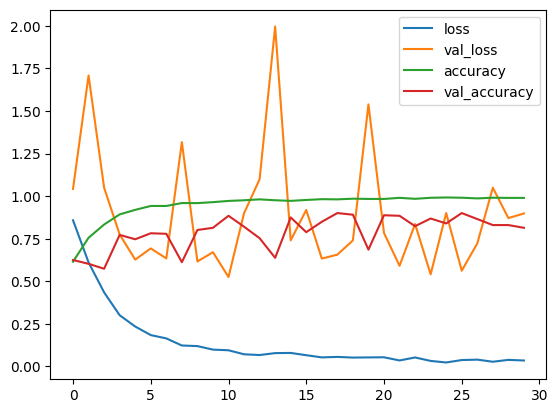

In [ ]:
hist = model_history.history

plt.plot(hist['loss'], label=  'loss')
plt.plot(hist['val_loss'], label = 'val_loss')
plt.plot(hist['sparse_categorical_accuracy'], label='accuracy')
plt.plot(hist['val_sparse_categorical_accuracy'], label='val_accuracy')
plt.legend()

In [ ]:
incept_model.evaluate(x=x_test, y = y_test, batch_size=32, verbose=1)

10/10 [==============================] - 1s 48ms/step - loss: 0.8983 - sparse_categorical_accuracy: 0.8141


[0.8983335494995117, 0.8141025900840759]

In [ ]:
# Now open the last 100 layers so that they becomes trainable
for layer in incept_model.layers[720:]: # i.e. after 30 blocks
    layer.trainable = True

In [ ]:
#Compile the model again, with lesser learning rate
incept_model.compile(optimizer=optimizers.RMSprop(.0001), loss=losses.sparse_categorical_crossentropy, metrics=[metrics.SparseCategoricalAccuracy()])


In [ ]:
earlyStop = keras.callbacks.EarlyStopping(patience=60)
best_model = keras.callbacks.ModelCheckpoint(filepath='best_model_2.h5', save_best_only=True)


model_history = incept_model.fit(x_train, y_train, batch_size=32, epochs=64, validation_data=(x_test, y_test), callbacks=[earlyStop, best_model])

Epoch 1/64
88/88 [==============================] - 11s 68ms/step - loss: 0.0216 - sparse_categorical_accuracy: 0.9936 - val_loss: 0.6158 - val_sparse_categorical_accuracy: 0.8782
Epoch 2/64
88/88 [==============================] - 5s 60ms/step - loss: 0.0095 - sparse_categorical_accuracy: 0.9972 - val_loss: 0.5748 - val_sparse_categorical_accuracy: 0.8910
Epoch 3/64
88/88 [==============================] - 4s 49ms/step - loss: 0.0058 - sparse_categorical_accuracy: 0.9979 - val_loss: 0.5880 - val_sparse_categorical_accuracy: 0.8878
Epoch 4/64
88/88 [==============================] - 5s 56ms/step - loss: 0.0047 - sparse_categorical_accuracy: 0.9982 - val_loss: 0.5733 - val_sparse_categorical_accuracy: 0.8910
Epoch 5/64
88/88 [==============================] - 5s 57ms/step - loss: 0.0070 - sparse_categorical_accuracy: 0.9972 - val_loss: 0.5783 - val_sparse_categorical_accuracy: 0.8846
Epoch 6/64
88/88 [==============================] - 5s 53ms/step - loss: 0.0059 - sparse_categorical_acc

In [ ]:
model_loss, model_acc = incept_model.evaluate(x=x_test, y = y_test, batch_size=32, verbose=1)

10/10 [==============================] - 0s 47ms/step - loss: 0.7414 - sparse_categorical_accuracy: 0.8878


In [ ]:
#Predict for a new image and display it
def predict_img(img_path, label):
    img1 = make_image(img_path) #preprocessing the image

    res = incept_model.predict(np.expand_dims(img1, axis=0)) #convert image into numpy array(actually 3d numpy array coz neural network trained was on 3d images) and predict
    pred = classes[np.argmax(res)]
    if pred==0:
      predicted = "benign"
    elif pred==1:
      predicted = "malignant"
    elif pred==2:
      predicted = "normal"

    #visualize the image:
    img = image.load_img(img_path)
    plt.imshow(np.array(img))
    plt.title(f'True Class: {label} \n Predicted Class:{pred}')


1/1 [==============================] - 0s 42ms/step


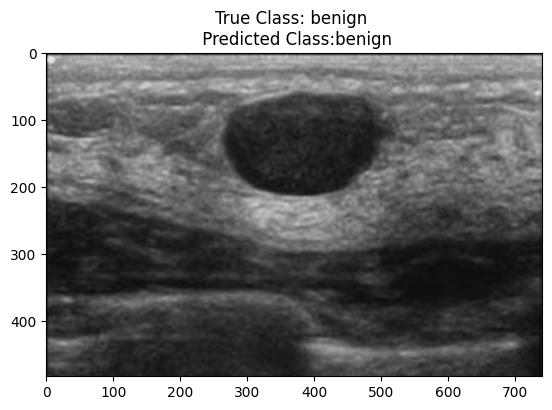

In [ ]:
predict_img(f'/content/im3.png', 'benign')

1/1 [==============================] - 0s 22ms/step


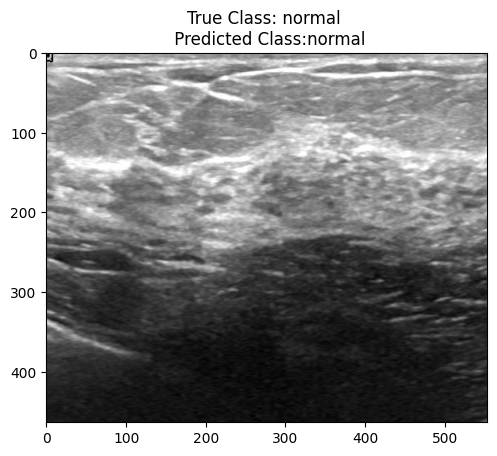

In [ ]:
predict_img(f'{dir_path}/normal/normal (15).png', 'normal')

1/1 [==============================] - 0s 42ms/step


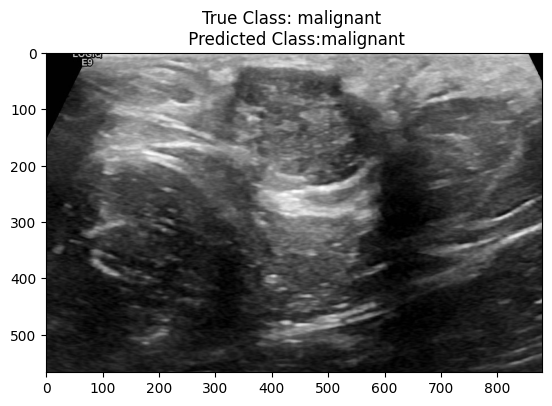

In [ ]:
predict_img(f'{dir_path}/malignant/malignant (78).png', 'malignant')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(incept_model)
# converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

with open("my_model88.tflite", "wb") as f:
    f.write(tflite_model)

In [ ]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [ ]:
# def get_file_size(file_path):
#     size = os.path.getsize(file_path)
#     return size

In [ ]:
TF_LITE_MODEL_FILE_NAME = "my_model88.tflite"

convert_bytes(os.path.getsize(TF_LITE_MODEL_FILE_NAME), "KB")


File size: 22551.395 Kilobytes


In [ ]:

#Function for evaluating TF Lite Model over Test Images
def evaluate(interpreter):
  prediction= []
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  input_format = interpreter.get_output_details()[0]['dtype']

  for i, test_image in enumerate(x_test):
    if i % 100 == 0:
      print('Evaluated on {n} results so far.'.format(n=i))
    test_image = np.expand_dims(test_image, axis=0).astype(input_format)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    interpreter.invoke()
    output = interpreter.tensor(output_index)
    predicted_label = np.argmax(output()[0])
    prediction.append(predicted_label)

  print('\n')
  # Comparing prediction results with ground truth labels to calculate accuracy.
  prediction = np.array(prediction)
  accuracy = (prediction == y_test).mean()
  return accuracy


In [ ]:
# Passing the FP-16 TF Lite model to the interpreter.
interpreter = tf.lite.Interpreter('/content/my_model88.tflite')
# Allocating tensors.
interpreter.allocate_tensors()
# Evaluating the model on the test dataset.
test_accuracy = evaluate(interpreter)
print('Float 16 Quantized TFLite Model Test Accuracy:', test_accuracy*100)
print('Baseline Keras Model Test Accuracy:', model_acc*100)

Evaluated on 0 results so far.
Evaluated on 100 results so far.
Evaluated on 200 results so far.
Evaluated on 300 results so far.


Float 16 Quantized TFLite Model Test Accuracy: 88.78205128205127
Baseline Keras Model Test Accuracy: 88.78205418586731
